<p align="center" width="100%">
    <img width="66%" src="https://raw.githubusercontent.com/linukc/master_dlcourse/main/images/logo.png">
</p>

# CRNN from scratch

Задача: распознавание текста на изображении с помощью CRNN модели  
Источник данных: https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database/data   
Гайд: https://wandb.ai/authors/text-recognition-crnn-ctc/reports/Text-Recognition-With-CRNN-CTC-Network--VmlldzoxNTI5NDI


### Загрузка данных


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!kaggle datasets download -d nibinv23/iam-handwriting-word-database

In [ ]:
!unzip iam-handwriting-word-database.zip

### Обзор данных

In [ ]:
import os
from PIL import Image
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
dataset_dir = Path('iam_words') # TODO: replace if needed

In [ ]:
def parse_words_txt(words_txt_path):
    data = []
    with words_txt_path.open() as f:
        for line in f:
            if line.startswith('#'):
                continue
            parts = line.strip().split(' ')
            if len(parts) >= 9:
                word_id = parts[0]
                segmentation_result = parts[1]
                graylevel = int(parts[2])
                bounding_box = list(map(int, parts[3:7]))
                grammatical_tag = parts[7]
                transcription = ' '.join(parts[8:])

                data.append({
                    'word_id': word_id,
                    'segmentation_result': segmentation_result,
                    'graylevel': graylevel,
                    'bounding_box': bounding_box,
                    'grammatical_tag': grammatical_tag,
                    'transcription': transcription,
                })
    return pd.DataFrame(data)

words_df = parse_words_txt(dataset_dir / 'words.txt')

In [ ]:
words_df

,word_id,segmentation_result,graylevel,bounding_box,grammatical_tag,transcription
0,a01-000u-00-00,ok,154,"[408, 768, 27, 51]",AT,A
1,a01-000u-00-01,ok,154,"[507, 766, 213, 48]",NN,MOVE
2,a01-000u-00-02,ok,154,"[796, 764, 70, 50]",TO,to
3,a01-000u-00-03,ok,154,"[919, 757, 166, 78]",VB,stop
4,a01-000u-00-04,ok,154,"[1185, 754, 126, 61]",NPT,Mr.
...,...,...,...,...,...,...
115315,r06-143-04-06,ok,186,"[1323, 1428, 64, 77]",PP3O,him
115316,r06-143-04-07,ok,186,"[1458, 1469, 36, 52]",IN,in
115317,r06-143-04-08,ok,186,"[1532, 1445, 73, 72]",ATI,the
115318,r06-143-04-09,ok,186,"[1654, 1444, 199, 114]",NN,garden


In [ ]:
def id2path(id):
    splitted = id.split('-')
    name = splitted[0] + '/' + '-'.join(splitted[:2]) + '/' + id
    return name + '.png'

In [ ]:
words_df['filename'] = words_df['word_id'].apply(id2path)
words_df['label_len'] = words_df['transcription'].apply(len)
words_df['word_area'] = words_df['bounding_box'].apply(lambda x: x[-1] * x[-2])
words_df.describe()

,graylevel,label_len,word_area
count,115320.000000,115320.000000,115320.000000
mean,174.998144,4.125061,12934.896644
std,13.846076,2.643954,13359.722715
min,128.000000,1.000000,1.000000
25%,167.000000,2.000000,4235.000000
50%,177.000000,3.000000,9180.000000
75%,183.000000,6.000000,17430.000000
max,224.000000,53.000000,275128.000000


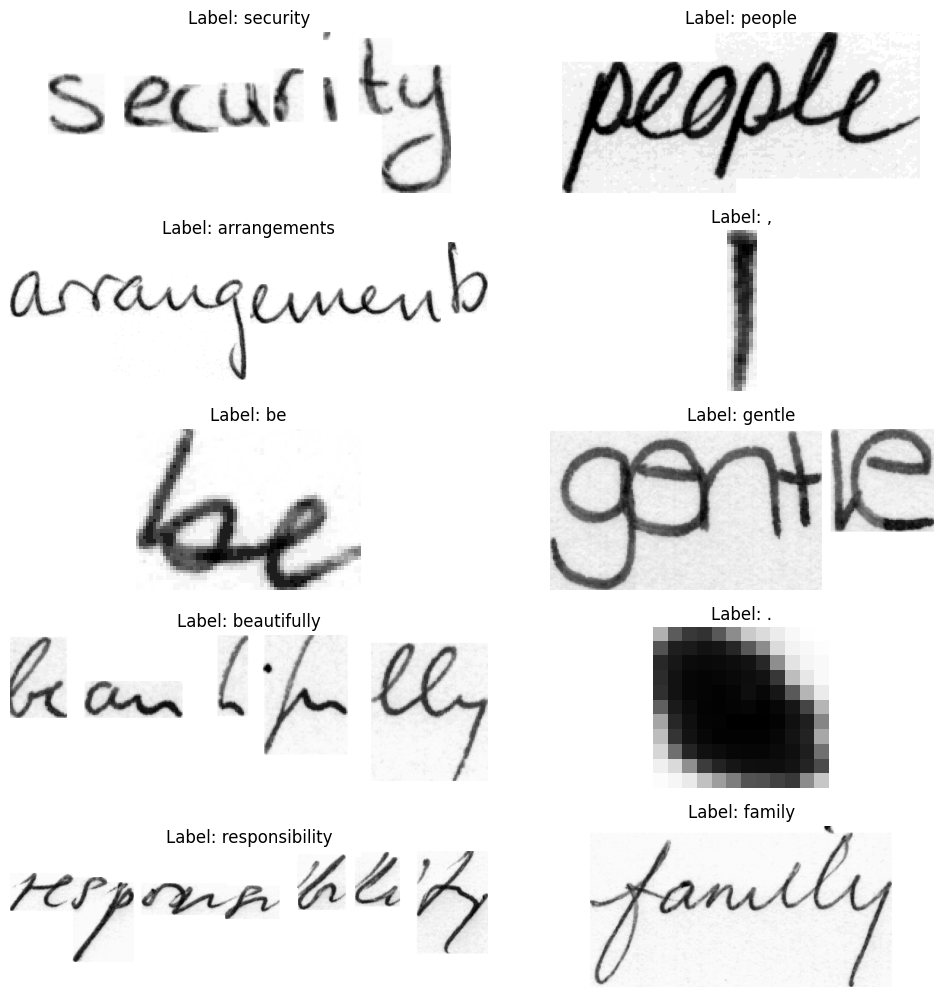

In [ ]:
def visualize_samples(image_paths, labels, root, num_samples=10):
    plt.figure(figsize=(10, num_samples * 2))

    for i, idx in enumerate(np.random.choice(len(image_paths), size=num_samples, replace=False)):
        image_path = image_paths[idx]
        label = labels[idx]
        img = Image.open(root / image_path)

        plt.subplot(num_samples, 2, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(
    words_df['filename'],
    words_df['transcription'],
    root=dataset_dir)

### Предобработка

In [ ]:
from PIL import ImageOps
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [ ]:
words_df = words_df.head(20_000)

In [ ]:
torch.manual_seed(42);

In [ ]:
vocab = set(char for label in words_df['transcription'] for char in label)
char2id = {char: id + 1 for id, char in enumerate(sorted(vocab))}
char2id['<PAD>'] = 0
blank_token_id = len(char2id)
char2id['<BLANK>'] = blank_token_id
id2char = ['<PAD>'] + sorted(vocab) + ['<BLANK>']
label_length = 19

In [ ]:
class IAMHandwritingDataset(Dataset):
    def __init__(self, image_paths, labels, char2id, root, transform=None):
        self.char2id = char2id
        self.transform = transform
        self.image_paths = [root / path for path in image_paths]
        self.labels = [self.__encode_label(label) for label in labels]

    def __len__(self):
        return len(self.image_paths)

    def __encode_label(self, label):
        label = [self.char2id[char] for char in label]
        label += [0] * (label_length - len(label))
        return np.array(label)

    def __getitem__(self, idx):
        try:
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('L')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            return self.__getitem__((idx + 1) % len(self.labels))

In [ ]:
class ResizeAspectWithPadding:
    def __init__(self, desired_size):
        self.desired_size = desired_size

    def __call__(self, img):
        img_ratio = img.size[0] / img.size[1]
        desired_ratio = self.desired_size[0] / self.desired_size[1]

        if img_ratio > desired_ratio:
            img = img.resize(
                (self.desired_size[0], int(self.desired_size[0] * img.size[1] / img.size[0])),
                Image.Resampling.LANCZOS)
        else:
            img = img.resize(
                (int(self.desired_size[1] * img.size[0] / img.size[1]), self.desired_size[1]),
                Image.Resampling.LANCZOS)

        delta_w = self.desired_size[0] - img.size[0]
        delta_h = self.desired_size[1] - img.size[1]
        padding = (0, 0, delta_w, delta_h)

        return ImageOps.expand(img, padding, fill=255)


target_size = (128, 32)
transform = transforms.Compose([
    ResizeAspectWithPadding(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
augment = transforms.Compose([
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomRotation(degrees=(0, 20), fill=(0,)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [ ]:
def collate_train(batch):
    images, labels = zip(*batch)
    images = [augment(img) for img in images]
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels

In [ ]:
dataset = IAMHandwritingDataset(
    words_df['filename'],
    words_df['transcription'],
    char2id=char2id,
    root=dataset_dir,
    transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_train, num_workers=3, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=3, drop_last=True)

### Архитектура

Базовая модель имеет архитектуру вида CRNN с простым CNN backbone и bi-directional LSTM head. В процессе кодирования высота изображения снижается до 1, чтобы затем рекуррентно пройтись по всем таймстемпам входа (соответствует проходу по изображению в горизональном направлении). На выходе применяется линейный слой -- получается матрица вероятностей каждого токена на каждом временном шагу.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import wandb
import time

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [ ]:
class CRNN(nn.Module):
    def __init__(self, nclass, nhidden, max_label_length, nc=1):
        super(CRNN, self).__init__()
        # CODE HERE
        pass

    def forward(self, x):
        # CODE HERE
        pass

### Обучение и тестирование

Модель работает на основе алгоритма CTC.
Источник: https://distill.pub/2017/ctc/

**CTC-loss**:
1. Расширение меток: Вводится специальный символ "blank" (обычно обозначаемый как "-"), который позволяет модели пропускать некоторые фрагменты входных данных.
2. Для каждого временного шага вычисляется распределение вероятностей по всем возможным символам, включая "blank".
3. Рассматриваются все возможные пути в матрице вероятностей, которые могут соответствовать истинной метке, включая различные вставки символа "blank" и повторения символов.
4. Вычисляется вероятность каждого возможного пути.  
5. Суммируются вероятности всех путей, которые соответствуют метке, и взятие логарифма этой суммы дает значение CTC-loss.

**CTC-decoding**:
Для алгоритма декодирования можно использовать различные варианты beam-search, в данном случае предлагается жадный алгоритм. После его применения происходит сжатие последовательности: удаление лишних дубликатов (которые не разделены blank символом), а также удаление самого blank.

![CTC](https://distill.pub/2017/ctc/assets/full_collapse_from_audio.svg)

In [ ]:
from evaluate import load
from tqdm.notebook import tqdm


def calc_loss(output, targets, target_lengths, criterion):
    # output: the output from the CRNN model, expected shape [T, b, nclass]
    # target: the encoded target labels, expected shape [sum(target_lengths)]
    # target_lengths: the lengths of the targets, expected shape [b]
    # return: loss
    # CODE HERE
    pass


def decode(sequence):
    if len(sequence) == 0: return '-'
    return ''.join([id2char[id] for id in sequence])


def greedy_ctc_decode(output, blank_label=blank_token_id):
    # output_probs: Tensor of shape (T, B, C) containing output probabilities from the model,
    # where T is the time steps, B is the batch size, and C is the number of classes (including the blank).
    # blank_label: The index of the CTC blank label.
    # return: strings
    # CODE HERE
    pass


def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        clear_labels = [l[l != 0] for l in labels]
        target_lengths = torch.tensor([len(l) for l in clear_labels], dtype=torch.long)
        targets = labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = calc_loss(output, targets, target_lengths, criterion)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

cer = load("cer")
def validate(model, dataloader, criterion):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_similarity = 0
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            clear_labels = [l[l != 0] for l in labels]
            target_lengths = torch.tensor([len(l) for l in clear_labels], dtype=torch.long)
            targets = labels.to(device)

            output = model(images)
            loss = calc_loss(output, targets, target_lengths, criterion)
            preds = greedy_ctc_decode(output.cpu())
            gts = [decode(label) for label in clear_labels]

            total_similarity += cer.compute(predictions=preds, references=gts)
            total_loss += loss.item()

        return total_loss / len(dataloader), total_similarity / len(dataloader)

2023-12-17 16:46:15.953742: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-17 16:46:16.004647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 16:46:16.891618: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
wandb.init(project='ocr_recognition')

# model settings
config = wandb.config
config.learning_rate = 1e-3
config.batch_size = 16
config.epochs = 50
config.rnn_hidden_size = 256
config.max_label_size = 19
config.nclass = len(char2id)

# model definitions
model = CRNN(
    nclass = config.nclass,
    nhidden = config.rnn_hidden_size,
    max_label_length = config.max_label_size)
criterion = nn.CTCLoss(blank=char2id['<BLANK>'])
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

# training with logging
best_loss = 10
for epoch in range(config.epochs):
    start_time = time.time()
    train_loss = train(model, train_dataloader, optimizer, criterion)
    val_loss, val_similarity = validate(model, val_dataloader, criterion)
    end_time = time.time()

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_cer": val_similarity,
        "epoch_time": end_time - start_time
    })

    if best_loss > val_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), f"best_model.pth")
        wandb.save(f"best_model.pth")

    print(f"Epoch {epoch+1}/{config.epochs}, " +
          f"Train Loss: {train_loss:.4f}, " +
          f"Val Loss: {val_loss:.4f}, " +
          f"Val CER: {val_similarity:.4f}, " +
          f"Epoch Time: {end_time - start_time:.2f}s")

wandb.finish()

#### Выводы


### Интерпретация SHAP

Для интерпретации использован градиентный метод. Высокие положительные значения указывают на то, что признак увеличивает вероятность данного прогноза, в то время как отрицательные значения указывают на уменьшение вероятности.

Ниже приведены визуализации SHAP для 2, 16 и 32 таймстемпов изображений соответственно.
На самом левом рисунке выделены приблизительные позиции целевых таймстемпов.
Правее располагаются 5 наиболее вероятных классов (по убыванию вероятности) и их SHAP-интерпретация.


In [ ]:
import shap

In [ ]:
class CRNNWrapper(nn.Module):
    def __init__(self, crnn_model, t):
        super().__init__()
        self.crnn_model = crnn_model
        self.t = t

    def forward(self, x):
        model_output = self.crnn_model(x)
        return model_output[self.t]

In [ ]:
def get_shap(model, images, timestamp=0, top_k=5):
    explainer = shap.GradientExplainer(CRNNWrapper(model, t=timestamp), images)
    shap_values, indexes = explainer.shap_values(images, ranked_outputs=top_k)
    normal_images = images.squeeze(1).unsqueeze(-1).numpy()
    normal_shap_values = [np.swapaxes(np.swapaxes(s, 1, -2), -2, -1) for s in shap_values]
    index_names = np.vectorize(lambda x: id2char[x])(indexes)
    normal_images = timestamps2images(normal_images, timestamp=timestamp)
    shap.image_plot(normal_shap_values, normal_images, index_names, show=False)
    plt.savefig(f"timestamp_{timestamp}.png", bbox_inches='tight')
    plt.close()
    return normal_shap_values, normal_images


def timestamps2images(batch_images, timestamp=0, num=38, color=0):
    # batch_images: A batch of 2D numpy arrays representing the grayscale image.
    # timestamps: A list of integers representing the x-coordinates for the timestamps.
    # color: Grayscale value of the lines (0 to 255 for grayscale images).
    # return: A new 2D numpy array with the vertical lines added.
    batch_with_lines = np.copy(batch_images)
    image_width = batch_images.shape[2]
    width_ratio = batch_images.shape[2] // num
    time_range = [timestamp * width_ratio, (timestamp + 1) * width_ratio]
    for i in range(len(batch_with_lines)):
        for t in time_range:
            if 0 <= t < image_width:
                batch_with_lines[i, :, t] = color

    return batch_with_lines

In [ ]:
model = CRNN(nclass = len(char2id), nhidden = 256, max_label_length = 19)
model.load_state_dict(torch.load("best_model.pth"))
model.eval();

{'encoding': 'utf-8'}


In [ ]:
test_iterator = iter(test_dataloader)
images_to_explain, _ = next(test_iterator)

In [ ]:
greedy_ctc_decode(model(images_to_explain[4:8]))

['this', 'are', 'this', 'the']

In [ ]:
wandb.init(project='ocr_recognition')

In [ ]:
for t in [2, 16, 32]:
    get_shap(model, images_to_explain[4:8], timestamp=t)
    wandb.log({f"SHAP for timestamp {t}": wandb.Image(f"timestamp_{t}.png")})

In [ ]:
wandb.finish()

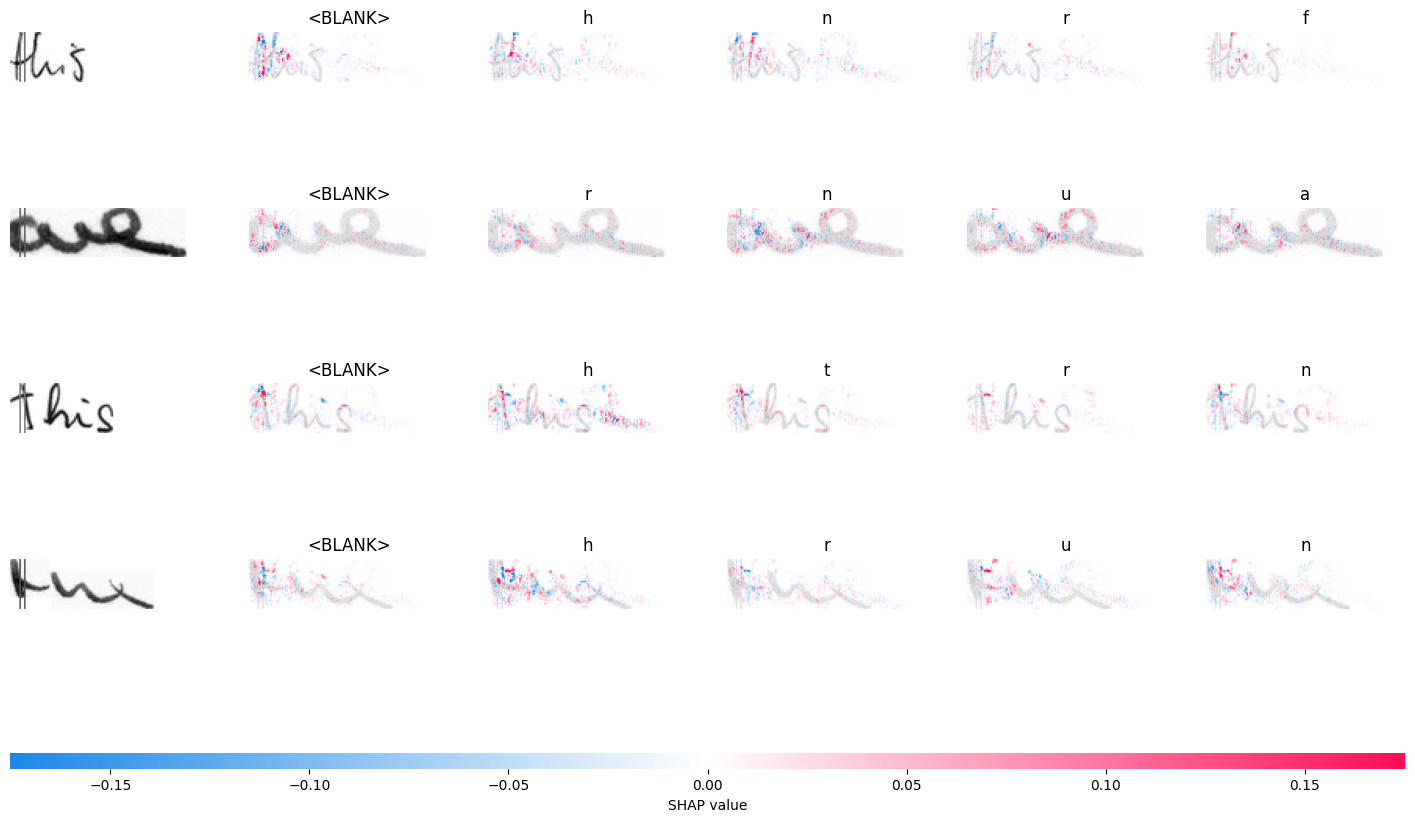

In [ ]:
Image.open(f"timestamp_2.png").convert("RGB")

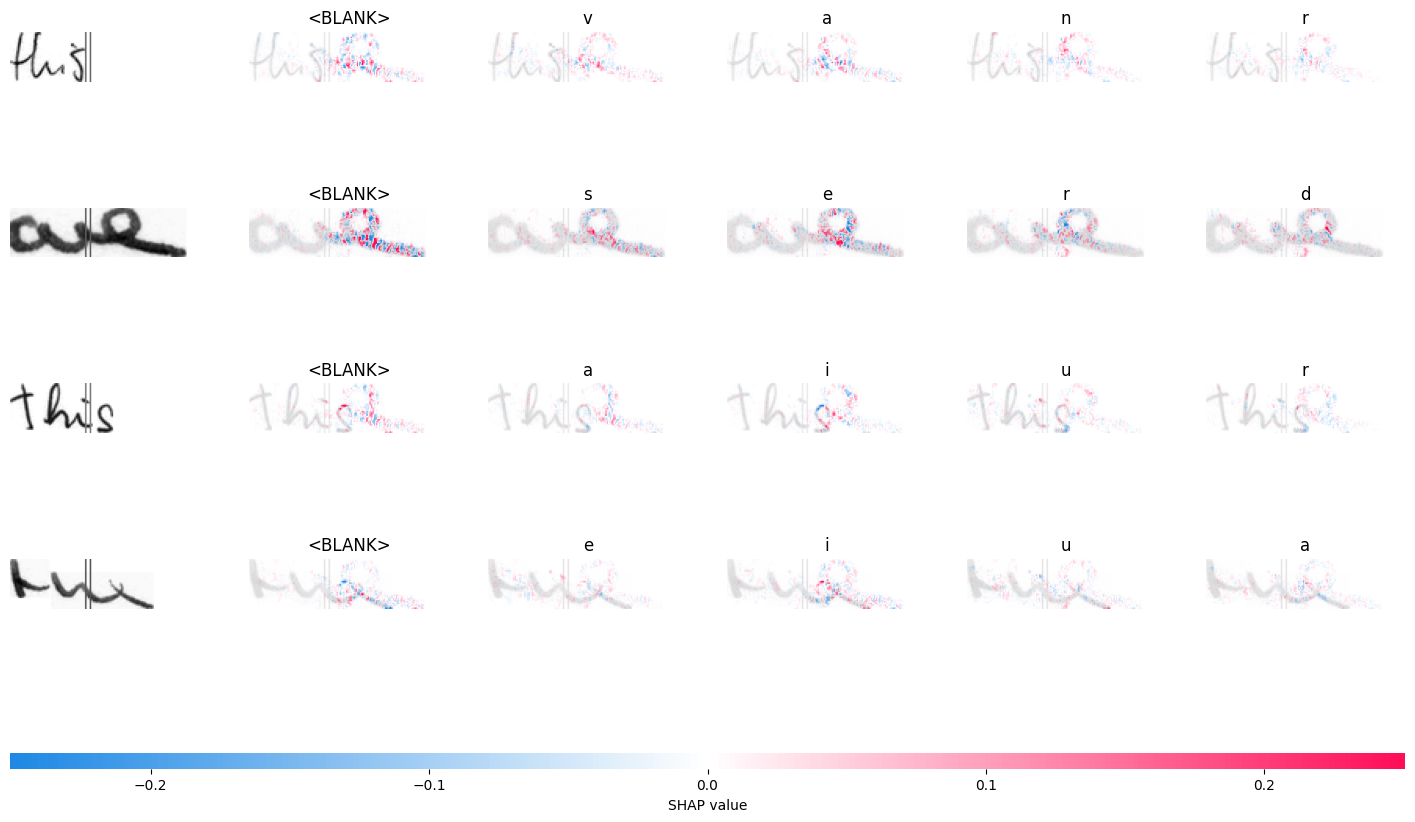

In [ ]:
Image.open(f"timestamp_16.png").convert("RGB")

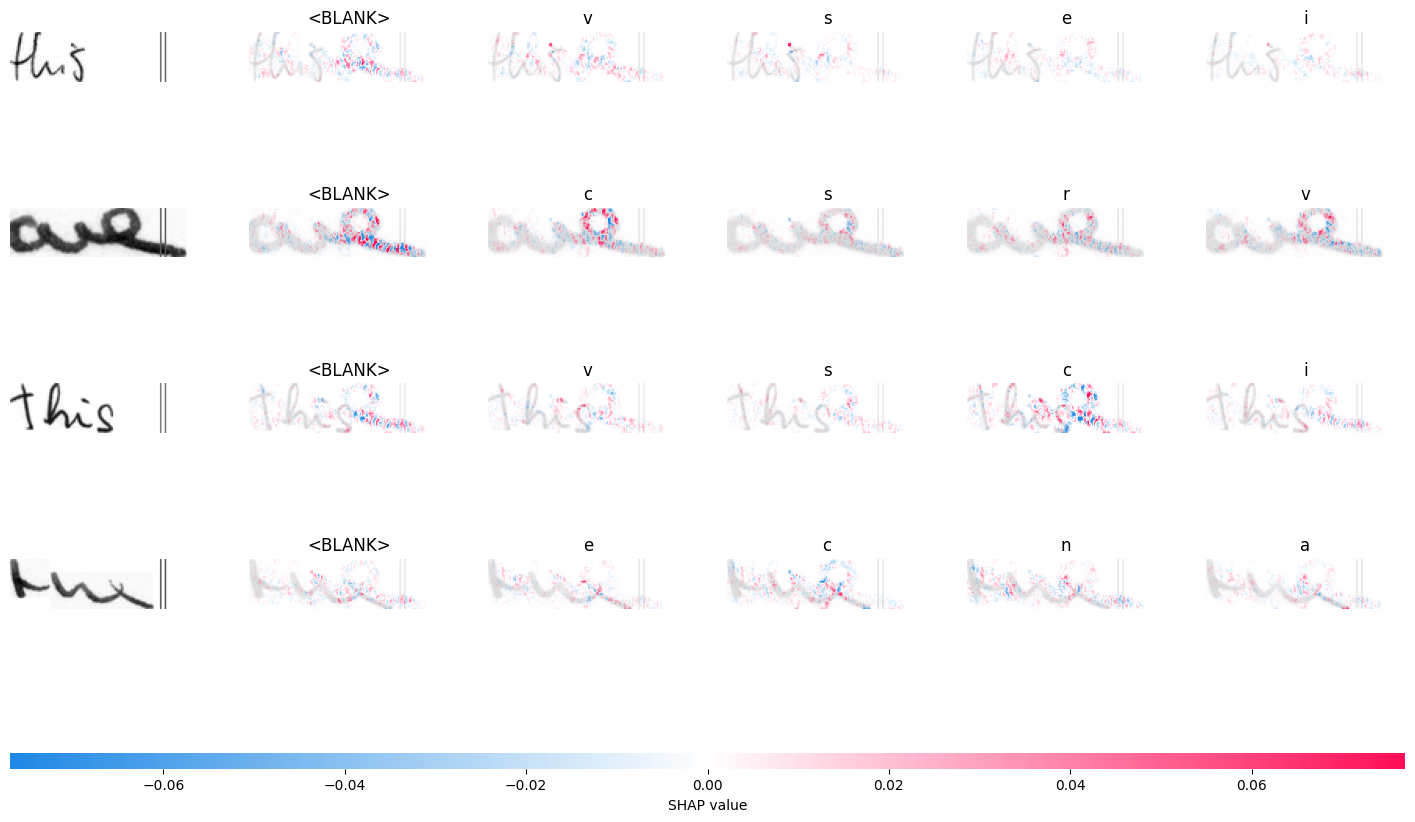

In [ ]:
Image.open(f"timestamp_32.png").convert("RGB")

#### Выводы